In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.lib.io import file_io

import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix
from seaborn import heatmap

%matplotlib inline

In [ ]:
print(tf.__version__)
print(keras.__version__)

2.8.2
2.8.0


In [ ]:
EPOCHS = 150
BS = 128
DROPOUT_RATE = 0.3
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=(48,48,3)))
model.add(Conv2D(32, (3,3), activation='relu',padding='same', input_shape=(48,48,3),name="conv1"))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool1"))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same',name="conv2"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool2"))         
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',name="conv3"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool3"))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',name="conv4"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool4"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1024, activation='relu',name='fc1'))
model.add(Dropout(DROPOUT_RATE))
model.add(BatchNormalization())
model.add(Dense(7, activation='softmax',name='fcsoftmax'))

#TODO: weight decay of 0.0001...initial learning rate is set to 0.01 and reduced by a factor of 2 at every 25 epoch
sgd = SGD(lr=SGD_LEARNING_RATE,momentum=0.9, decay=SGD_DECAY, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

# checkpoint
cp_filepath='/content/drive/My Drive/DATASET/models/Baseline-weights-best.hdf5'
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(cp_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [rlrop,checkpoint]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
%%bash
root='/content/drive/MyDrive/DATASET/online split/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

Angry: 1080
Disgust: 1040
Fear: 1073
Happy: 1137
Neutral: 1112
Sad: 1105
Surprise: 1112


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(48, 48),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [ ]:
train_generator  = get_datagen('/content/drive/MyDrive/DATASET/online split/train', True)
dev_generator    = get_datagen('/content/drive/MyDrive/DATASET/online split/val')
test_generator  = get_datagen('/content/drive/MyDrive/DATASET/online split/test')


Found 2052 images belonging to 7 classes.
Found 261 images belonging to 7 classes.
Found 256 images belonging to 7 classes.


In [ ]:
history = model.fit(
    x = train_generator,
    validation_data=dev_generator, 
    #steps_per_epoch=28709// BS,
    #validation_steps=3509 // BS,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=callbacks_list,
#    callbacks=[rlrop],
    use_multiprocessing=False,
    verbose=1
) 

Epoch 1/150
17/17 [==============================] - ETA: 0s - loss: 2.5368 - accuracy: 0.1725 
Epoch 1: val_accuracy improved from -inf to 0.15326, saving model to /content/drive/My Drive/DATASET/models/Baseline-weights-best.hdf5
17/17 [==============================] - 1118s 65s/step - loss: 2.5368 - accuracy: 0.1725 - val_loss: 2.0879 - val_accuracy: 0.1533 - lr: 0.0100
Epoch 2/150
17/17 [==============================] - ETA: 0s - loss: 2.4030 - accuracy: 0.2105
Epoch 2: val_accuracy improved from 0.15326 to 0.15709, saving model to /content/drive/My Drive/DATASET/models/Baseline-weights-best.hdf5
17/17 [==============================] - 8s 477ms/step - loss: 2.4030 - accuracy: 0.2105 - val_loss: 2.1183 - val_accuracy: 0.1571 - lr: 0.0100
Epoch 3/150
17/17 [==============================] - ETA: 0s - loss: 2.2733 - accuracy: 0.2315
Epoch 3: val_accuracy improved from 0.15709 to 0.20690, saving model to /content/drive/My Drive/DATASET/models/Baseline-weights-best.hdf5
17/17 [=======

In [ ]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate(dev_generator)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
3/3 [==============================] - 1s 275ms/step - loss: 1.4230 - accuracy: 0.4789
dev loss, dev acc: [1.423043966293335, 0.4789271950721741]


In [ ]:
print('\n# Evaluate on test data')
results_test = model.evaluate(test_generator)
print('test loss, test acc:', results_test)


# Evaluate on test data
2/2 [==============================] - 72s 72s/step - loss: 1.3758 - accuracy: 0.4648
test loss, test acc: [1.3757781982421875, 0.46484375]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


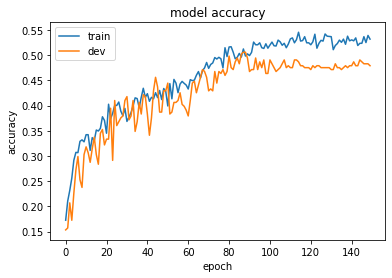

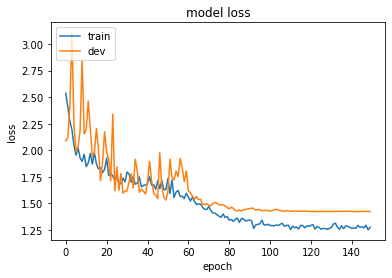

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
dropout_str = '-DROPOUT_' + str(DROPOUT_RATE)
test_acc = '-test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/DATASET/models/' + 'SOA' + epoch_str + dropout_str + test_acc + '.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


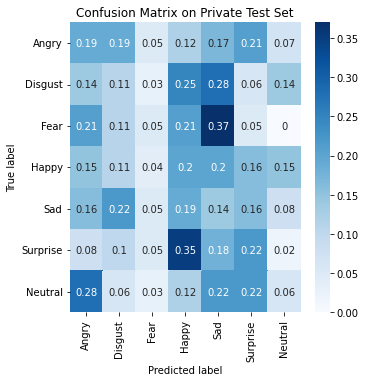

In [ ]:
emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

y_pred = model.predict_generator(dev_generator).argmax(axis=1)
y_true = dev_generator.classes

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='true').round(2),
  index=emotions.values(), 
  columns=emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on Private Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
# configure image data augmentation
datagen = ImageDataGenerator(horizontal_flip=True)

# make a prediction using test-time augmentation
def tta_prediction(datagen, model, image, n_examples):
	# convert image into dataset
	samples = np.expand_dims(image, 0)
	# prepare iterator
	it = datagen.flow(samples, batch_size=n_examples)
	# make predictions for each augmented image
	yhats = model.predict_generator(it, steps=n_examples, verbose=0)
	# sum across predictions
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	return np.argmax(summed)
 
 # evaluate a model on a dataset using test-time augmentation
def tta_evaluate_model(model, testX, testY):
	# configure image data augmentation
	datagen = ImageDataGenerator(horizontal_flip=True)
	# define the number of augmented images to generate per test set image
	n_examples_per_image = 7
	yhats = list()
	for i in range(len(testX)):
		# make augmented prediction
		yhat = tta_prediction(datagen, model, testX[i], n_examples_per_image)
		# store for evaluation
		yhats.append(yhat)
	# calculate accuracy
	testY_labels = np.argmax(testY, axis=1)
	acc = accuracy_score(testY_labels, yhats)
	return acc

In [ ]:
print('\n# Evaluate on test data')
#TTA_results_test = tta_evaluate_model(model, X_test, Y_test)
print('test loss, test acc:', results_test)
# print('TTA test acc:', TTA_results_test)


# Evaluate on test data
test loss, test acc: [1.3757781982421875, 0.46484375]
